Source: https://sec-api.io/resources/fama-french-factor-model
Data F-F_Research_Data_Factors.csv from: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

In [99]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


style.use("default")

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "text.usetex": False,
    "font.family": "sans-serif", "axes.spines.top": False, "axes.spines.right": False,
    "grid.color": "grey", "axes.grid": True,  "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

[*********************100%***********************]  1 of 1 completed


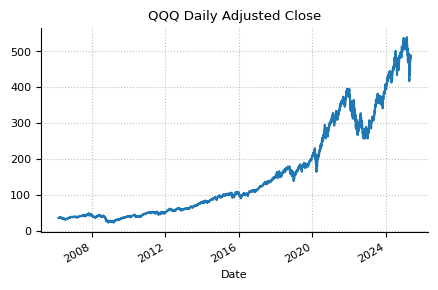

In [100]:
# use Yahoo Finance to download historical data for QQQ
# over the last 15 years, from 2006-01-01 to 2021-01-01
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=7000)
qqq_daily = yf.download("QQQ", start=startDate, end=endDate)
qqq_daily.columns = qqq_daily.columns.droplevel('Ticker')
qqq_daily = qqq_daily[['High','Low','Open','Close','Volume']]
qqq_daily["Close"].plot(title="QQQ Daily Adjusted Close", figsize=(5, 3))
plt.show()

In [101]:
# calculate monthly returns of QQQ
qqq_monthly = qqq_daily["Close"].resample("M").ffill().to_frame()
qqq_monthly.index = qqq_monthly.index.to_period("M")
qqq_monthly["Return"] = qqq_monthly["Close"].pct_change() * 100
qqq_monthly.dropna(inplace=True)
qqq_monthly

,Close,Return
Date,,
2006-04,35.972507,-0.190823
2006-05,33.368069,-7.240081
2006-06,33.347500,-0.061642
2006-07,31.911066,-4.307471
2006-08,33.433521,4.770932
...,...,...
2025-01,521.512268,2.163401
2025-02,507.413330,-2.703472
2025-03,468.920013,-7.586186


In [102]:
def convert_to_date(x):
    x_str = str(x).strip() 
    if len(x_str) == 6:  # YYYYMM
        return pd.to_datetime(x_str + '01', format='%Y%m%d')
    elif len(x_str) == 4:  # YYYY
        return pd.to_datetime(x_str + '0101', format='%Y%m%d')
    else:
        return pd.NaT  # Not a valid date format

In [103]:
ff_factors_monthly = pd.read_csv("F-F_Research_Data_Factors.csv")
ff_factors_monthly = ff_factors_monthly.rename(columns={'Unnamed: 0':'Date'})
ff_factors_monthly['Date'] = ff_factors_monthly['Date'].apply(convert_to_date)
ff_factors_monthly = ff_factors_monthly.set_index(ff_factors_monthly['Date'])
ff_factors_monthly = ff_factors_monthly.drop(columns='Date')

In [104]:
# Step 2: Load the monthly three factors into a dataframe
# CSV columns: , Mkt-RF, SMB, HML, RF
# The first columns represents the date
# The first row contains the column names
ff_factors_monthly = pd.read_csv("F-F_Research_Data_Factors.csv")
ff_factors_monthly = ff_factors_monthly.rename(columns={'Unnamed: 0':'Date'})
ff_factors_monthly['Date'] = ff_factors_monthly['Date'].apply(convert_to_date)
ff_factors_monthly = ff_factors_monthly.set_index(ff_factors_monthly['Date'])
ff_factors_monthly = ff_factors_monthly.drop(columns='Date')
ff_factors_monthly.index = ff_factors_monthly.index.to_period("M")
ff_factors_monthly

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2020-01,23.66,12.72,-46.10,0.45
2021-01,23.57,-3.78,25.39,0.04
2022-01,-21.58,-7.04,25.97,1.43


In [105]:
# Filter factor dates to match the asset
ff_factors_subset = ff_factors_monthly[
    ff_factors_monthly.index.isin(qqq_monthly.index)
].copy()
qqq_monthly = qqq_monthly[
    qqq_monthly.index.isin(ff_factors_subset.index)
]
ff_factors_subset = ff_factors_subset[~ff_factors_subset.index.duplicated()]
# Step 3: Calculate excess returns for the asset
ff_factors_subset["Excess_Return"] = qqq_monthly["Return"] - ff_factors_subset["RF"].astype('float')
ff_factors_subset

,Mkt-RF,SMB,HML,RF,Excess_Return
Date,,,,,
2006-04,0.73,-1.42,2.34,0.36,-0.550823
2006-05,-3.57,-2.96,2.41,0.43,-7.670081
2006-06,-0.35,-0.39,0.85,0.40,-0.461642
2006-07,-0.78,-3.98,2.60,0.40,-4.707471
2006-08,2.03,1.03,-2.06,0.42,4.350932
...,...,...,...,...,...
2024-08,1.61,-3.55,-1.13,0.48,0.623873
2024-09,1.74,-0.17,-2.59,0.40,2.221597
2024-10,-0.97,-1.01,0.89,0.39,-1.254632


In [107]:
# Prepare the independent variables (add a constant to the model)
X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML"]])
# The dependent variable
y = ff_factors_subset["Excess_Return"]
X = X.apply(pd.to_numeric, errors='coerce')  # Convert all columns of X to numeric, turning non-numeric into NaN
y = pd.to_numeric(y, errors='coerce')       # Convert y to numeric
# Run the regression
model = sm.OLS(y, X).fit()
# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     701.2
Date:                Wed, 07 May 2025   Prob (F-statistic):          1.35e-112
Time:                        19:13:43   Log-Likelihood:                -431.17
No. Observations:                 225   AIC:                             870.3
Df Residuals:                     221   BIC:                             884.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2184      0.113      1.932      0.0